In [3]:
!pip install pymatgen -q

In [1]:
from fastai import *
from fastai.vision.all import *

import sys
sys.path.append('..')
from src.band_plotters import *
from src.transforms import Binarize
from src.TensorImageNoised import *

import model

## Load

torch.Size([32, 3, 224, 224])

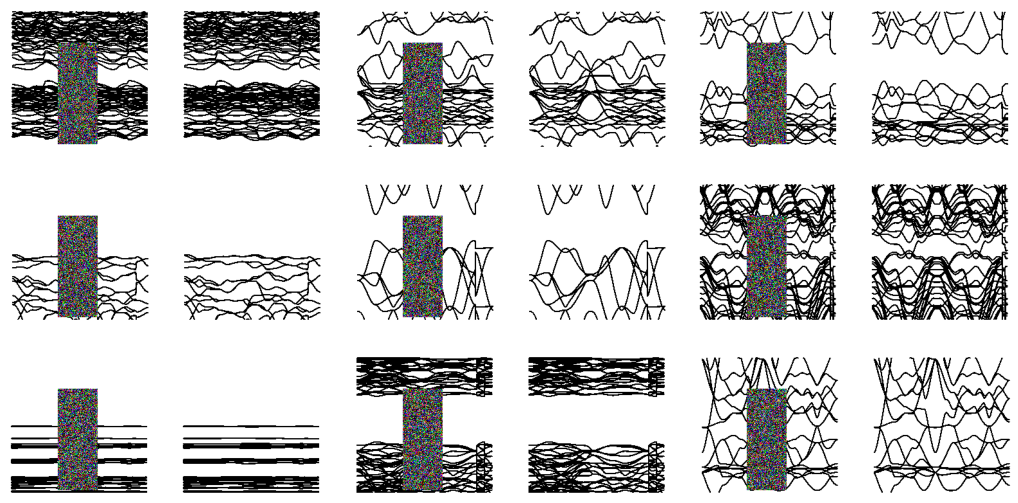

In [5]:
IMAGE_SIZE = 224
Z_CHANNELS = 2

dls = DataBlock(
    blocks=(ImageBlock(cls=PILImageNoised), ImageBlock), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.05, seed=42),
    item_tfms=[Resize((IMAGE_SIZE))],
    batch_tfms=[Binarize(), RandomErasingTransform()]
        ).dataloaders(DATA_DIRECTORY/f"images", bs=32)

dls.show_batch()

xb, yb = dls.one_batch()
xb.shape

## Train

### Create Learner

In [7]:
loss = nn.BCEWithLogitsLoss()
sigmoid = True
if isinstance(loss, nn.BCEWithLogitsLoss):
    sigmoid = False

epoch,train_loss,valid_loss,time
0,0.362777,0.358919,08:36
1,0.355098,0.347482,07:57
2,0.346664,0.337756,07:55
3,0.337413,0.334559,08:11
4,0.335999,0.331075,08:06
5,0.335655,0.330569,08:14
6,0.335317,0.327834,08:17
7,0.328320,0.321712,08:13
8,0.325988,0.326673,08:19
9,0.323080,0.319819,08:20


Better model found at epoch 0 with valid_loss value: 0.3589189350605011.


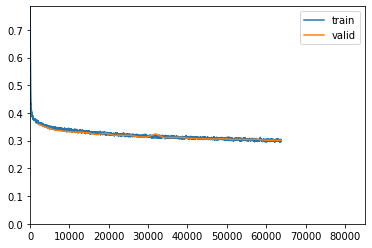

Better model found at epoch 1 with valid_loss value: 0.34748154878616333.
Better model found at epoch 2 with valid_loss value: 0.3377564549446106.
Better model found at epoch 3 with valid_loss value: 0.3345588743686676.
Better model found at epoch 4 with valid_loss value: 0.3310745060443878.
Better model found at epoch 5 with valid_loss value: 0.3305685818195343.
Better model found at epoch 6 with valid_loss value: 0.32783418893814087.
Better model found at epoch 7 with valid_loss value: 0.32171207666397095.
Better model found at epoch 9 with valid_loss value: 0.3198191523551941.
Better model found at epoch 10 with valid_loss value: 0.3193625807762146.
Better model found at epoch 11 with valid_loss value: 0.31924423575401306.
Better model found at epoch 12 with valid_loss value: 0.3135175406932831.
Better model found at epoch 13 with valid_loss value: 0.3134756088256836.
Better model found at epoch 15 with valid_loss value: 0.311149001121521.
Better model found at epoch 18 with valid_l

In [ ]:
model_names = ["resnet18"]
n_epochs = 30

for model_name in model_names:
    ae = model.BuildAutoEncoder(model_name, sigmoid=sigmoid, z_channels=Z_CHANNELS)
    learn = Learner(dls, ae, loss, cbs=[ShowGraphCallback(), SaveModelCallback(fname=f"./mp_models/{model_name}")])
    learn.fit_one_cycle(40)

xb, yb = dls.valid.one_batch()
print("latent size:", learn.model.encoder(xb.cuda()).shape)

## Save and Load Learner

In [8]:
# learn.export(f"trained_models/resnet18_size{IMAGE_SIZE}_lossbce_channels{Z_CHANNELS}.pkl")
learn = load_learner("trained_models/resnet18_size224_lossbce_channels2.pkl")

## View Predictions

In [13]:
from ipywidgets import interact

train = False

if train:
    dl = dls.train
else:
    dl = dls.valid
xb, yb = dl.one_batch()
sigmoid=False

def show(i):
    print(dl.items[i])
    learn.cuda()
    preds = learn.model(xb)
    if not sigmoid:
        preds = torch.sigmoid(preds)
    show_image(xb[i])
    show_image(preds[i])
    
    if not train:
        show_image(yb[i])
    
    # image = Image.open(dl.items[i])
    # image.show()

    

interact(show, i=(0, len(xb)-1))

interactive(children=(IntSlider(value=15, description='i', max=31), Output()), _dom_classes=('widget-interact'…

<function __main__.show(i)>

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


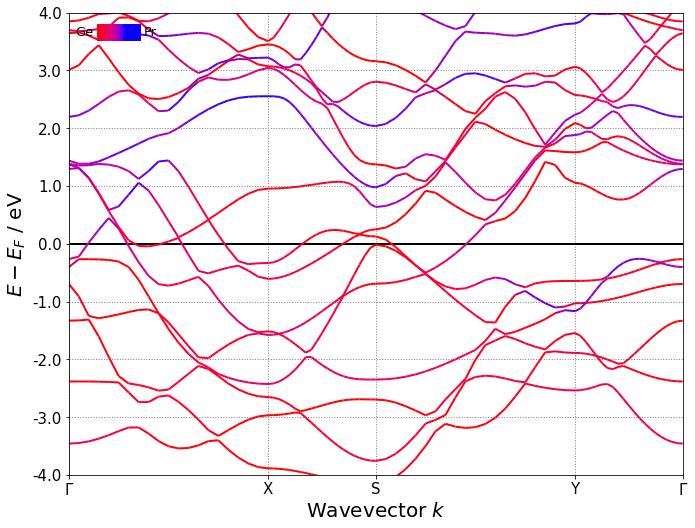

In [49]:
plot("2dm-5299", dos=False)

## Create Pickles from Weights for Easy Loading

In [11]:
model_names = ["resnet18", "resnet34", "resnet50"]

for model_name in model_names:
    ae = model.BuildAutoEncoder(model_name, sigmoid=sigmoid, z_channels=Z_CHANNELS)
    learn = Learner(dls, ae, loss, cbs=[ShowGraphCallback(), SaveModelCallback(fname=f"./mp_models/{model_name}")])
    model_location = f"./models/mp_models/{model_name}"
    learn.load(f"./mp_models/{model_name}")
    learn.export(model_location+".pkl")

/usr/local/lib/python3.9/dist-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")
/usr/local/lib/python3.9/dist-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")
/usr/local/lib/python3.9/dist-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")
